# Simulate a user accessing scenes to estimate # of sectors needed to unseal

## Imports

In [137]:
%matplotlib inline
import random
import geopandas as gpd
from scipy.spatial import KDTree
import numpy as np

## Prepare Landsat scenes (Rows/Paths) of the US

### Fetch files

In [25]:
# From https://www.usgs.gov/media/files/landsat-wrs-2-descending-path-row-shapefile
landsat_scenes_shp = gpd.read_file("https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/WRS2_descending_0.zip")

# From https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
us_states_shp = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_20m.zip")

# From https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
msa_boundaries = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_cbsa_20m.zip")

### Reproject to WGS84 (to match Landsat)

In [26]:
us_states_shp = us_states_shp.to_crs(epsg=4326)
msa_boundaries = msa_boundaries.to_crs(epsg=4326)

### Clip Scenes to Continential US 

In [28]:
us_states_continential = us_states_shp[us_states_shp["STUSPS"].isin(["AK", "HI", "PR", "VI", "GU", "AS", "MP", "UM"]) == False]
landsat_scenes_clipped = gpd.clip(landsat_scenes_shp, us_states_continential)
print(len(landsat_scenes_clipped)) # Should be about 457 scenes

457


/Users/jsolly.admin/Documents/code/easier/venv/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


## Remove unused fields

In [83]:
landsat_scenes_clipped_truncated = landsat_scenes_shp[["PATH", "ROW", "geometry"]]
landsat_scenes_clipped_rows_paths_only = landsat_scenes_shp[["PATH", "ROW"]].values
us_states_shp_truncated = us_states_shp[["geometry"]]
msa_boundaries_truncated = msa_boundaries[["CBSAFP", "geometry"]]

## Intersect MSAs with Landsat scenes

In [65]:
msa_boundaries_intersect= gpd.sjoin(msa_boundaries_truncated, landsat_scenes_clipped, how="inner", op="intersects")

/Users/jsolly.admin/Documents/code/easier/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3318: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


## Drop Geometry of MSAs

In [144]:
msa_boundaries_intersect_drop_geom = msa_boundaries_intersect[["CBSAFP", "PATH", "ROW"]]

In [145]:
msa_boundaries_intersect_drop_geom

,CBSAFP,PATH,ROW
0,34780,26,36
243,22900,26,36
364,20460,26,36
506,45500,26,36
710,32540,26,36
...,...,...,...
925,33540,41,28
934,12620,12,28
934,12620,11,28
934,12620,10,28


## User Settings

In [ ]:
scenes_requested_per_request = random.randint(1, 5)
number_of_requests = 1000

## Sector and Cache Settings

In [ ]:
cache_time = 1000 # Number of requests (loops) before hot storage cache is cleared
cache_hit_count = 0
sector_scene_count = 25
sector_packing_method = "random-greedy" # "random-greedy" or "sequential"

## Pack Sectors

In [85]:
scenes = landsat_scenes_clipped_rows_paths_only
tree = KDTree(scenes)

car_scenes = [] # Each car will have a list of scenes that will be used to pack it. len(car_scenes) = scenes / 25
scene = random.choice(scenes)

while True: # Keep packing as long as there are still scenes left
    k_nearest_neighbors = tree.query(scene, k=25) # Pack each CAR file with 25 scenes
    try:
        car_scenes.append([scenes[i] for i in k_nearest_neighbors[1]])
    except IndexError:
        break
    scenes = [v for i, v in enumerate(scenes) if i not in k_nearest_neighbors[1]] # Remove the scenes that were packed into the CAR file
    tree = KDTree(scenes) # Rebuild tree with nearest neighbors removed
    scene = random.choice(scenes)

car_scenes

[[array([105,   3]),
  array([106,   3]),
  array([105,   4]),
  array([104,   3]),
  array([105,   2]),
  array([106,   2]),
  array([104,   4]),
  array([104,   2]),
  array([106,   4]),
  array([103,   3]),
  array([107,   3]),
  array([105,   1]),
  array([105,   5]),
  array([103,   2]),
  array([107,   2]),
  array([106,   5]),
  array([103,   4]),
  array([104,   1]),
  array([106,   1]),
  array([104,   5]),
  array([107,   4]),
  array([107,   5]),
  array([107,   1]),
  array([103,   5]),
  array([103,   1])],
 [array([77, 99]),
  array([ 77, 100]),
  array([77, 98]),
  array([76, 99]),
  array([78, 99]),
  array([76, 98]),
  array([ 76, 100]),
  array([ 78, 100]),
  array([78, 98]),
  array([75, 99]),
  array([77, 97]),
  array([ 77, 101]),
  array([79, 99]),
  array([ 75, 100]),
  array([ 76, 101]),
  array([76, 97]),
  array([ 79, 100]),
  array([ 78, 101]),
  array([78, 97]),
  array([79, 98]),
  array([75, 98]),
  array([ 79, 101]),
  array([ 75, 101]),
  array([75, 97])

In [108]:
len(landsat_scenes_clipped_rows_paths_only)

28892

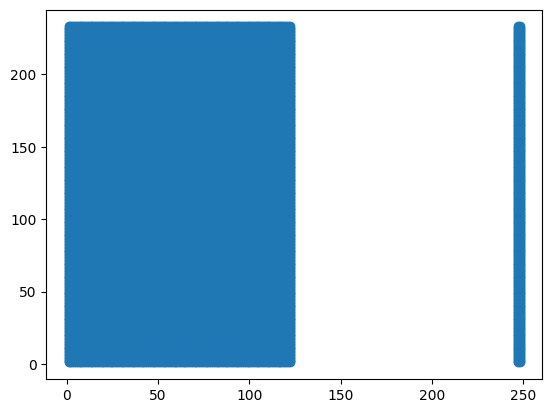

In [135]:
xs = [landsat_scenes_clipped_rows_paths_only[i][1] for i in range(len(landsat_scenes_clipped_rows_paths_only))]
ys = [landsat_scenes_clipped_rows_paths_only[i][0] for i in range(len(landsat_scenes_clipped_rows_paths_only))]

## Simulate User Access

## Plot Results